In [1]:
import fenics as fe
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from mshr import *

# fe.PETScOptions.set("snes_linesearch_monitor", "")
fe.PETScOptions.set("snes_linesearch_type", "bt")

In [2]:
N_POINTS_P_AXIS = 100
TIME_STEP_LENGTH = 0.2
TOTAL_TIME = 20
N_TIME_STEPS = np.floor(TOTAL_TIME/TIME_STEP_LENGTH).astype(int)
KINEMATIC_VISCOSITY = fe.Constant(0.01)
time_vector = np.arange(0.0, TOTAL_TIME, TIME_STEP_LENGTH)

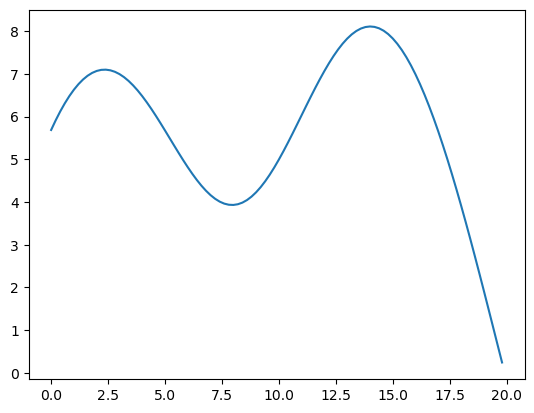

In [3]:
np.random.seed(50)

def generate_gauss():
    
    """The function returns the Gaussian processes A(t) and P(t). 
         See Regazzoni et al."""
    
    mu = 0.0
    tau = 5.0
    sigma = 5.0
  
    # Covariance kernel function
    def covariance_kernel(t1, t2):
        return sigma**2 * np.exp(-((t1 - t2)**2) / (2 * tau**2))

    # Generate samples of A(t) and P(t) using the covariance kernel
    mean = mu*np.ones(N_TIME_STEPS)
    covariance_matrix = np.fromfunction(np.vectorize(lambda i, j: covariance_kernel(time_vector[i], time_vector[j])), (N_TIME_STEPS, N_TIME_STEPS), dtype=int)
    A_t = np.random.multivariate_normal(mean, covariance_matrix)
    #P_t = np.random.multivariate_normal(mean, covariance_matrix)

    return A_t 

A_t = generate_gauss()
u_t = A_t
plt.plot(time_vector, A_t)

def eval_u_t(t):
    return u_t[np.where(np.abs(time_vector - t) < 1e-3)[0][0]]



In [4]:
# Define an expression for the BC u_t
class u_t_Expression(fe.UserExpression):
    def __init__(self, t, **kwargs):
        super().__init__(**kwargs)
        self.t = t
    def eval(self, value, x):
        value[0] = eval_u_t(self.t)
        value[1] = 0.0
    def value_shape(self):
        return (2,) 

In [5]:
# Create XDMF files for visualization output
xdmffile_u = fe.XDMFFile('lid_cavity_u_nl.xdmf')
xdmffile_p = fe.XDMFFile('lid_cavity_p_nl.xdmf')
xdmffile_u.parameters["flush_output"] = True
xdmffile_u.parameters["functions_share_mesh"] = True
xdmffile_p.parameters["flush_output"] = True
xdmffile_p.parameters["functions_share_mesh"] = True

In [6]:
class BottomVertex(fe.SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0]) < fe.DOLFIN_EPS and abs(x[1]) < fe.DOLFIN_EPS)

In [7]:
def main():
    
    # mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS, "crossed") # this is a triangular-element mesh
    domain = Rectangle(fe.Point(0., 0.), fe.Point(1., 1.))
    mesh = generate_mesh(domain, N_POINTS_P_AXIS)
   
    # Taylor-Hood Elements. 
    element_v = fe.VectorElement("Lagrange", mesh.ufl_cell(), 2)
    element_p = fe.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    W = fe.FunctionSpace(mesh, fe.MixedElement(element_v, element_p))
    V = fe.FunctionSpace(mesh, element_v)
    Q = fe.FunctionSpace(mesh, element_p)

    # Define trial functions
    vq = fe.TestFunction(W)
    delta_up = fe.TrialFunction(W)
    (v, q) = fe.split(vq)

    up = fe.Function(W)
    (u, p) = fe.split(up)

    up_prev = fe.Function(W)
    (u_prev, _) = fe.split(up_prev)

    # Define boundary conditions
    g = u_t_Expression(t = 0.0) 
    noslip = fe.DirichletBC(W.sub(0), (0, 0), "x[0] < DOLFIN_EPS || x[0] > 1.0 - DOLFIN_EPS || x[1] < DOLFIN_EPS")
    lid = fe.DirichletBC(W.sub(0), g, "x[1] > 1.0 - DOLFIN_EPS")
    pref = fe.DirichletBC(W.sub(1), 0, "x[0] < DOLFIN_EPS && x[1] < DOLFIN_EPS", "pointwise")

    bc = [noslip, lid, pref]

    # Stabilization if needed
    # h = fe.CellDiameter(mesh)
    # alpha_u = fe.Constant(1.)
    # delta_u = alpha_u*(h**2)
    # alpha_p = fe.Constant(1.)
    # delta_p = alpha_p*(h**2)
    # rho = fe.Constant(0.)
    # rho =   0 -> SUPG (Streamline updwind Petrov Galerkin)
    # rho =   1 -> GALS (Galerkin least squares)
    # rho = - 1 -> Douglas-Wang

    # Tentative velocity step
    F = fe.inner(u, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        - fe.inner(u_prev, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        + fe.inner(fe.grad(u) * u, v) * fe.dx \
        + KINEMATIC_VISCOSITY * fe.inner(fe.grad(u), fe.grad(v)) * fe.dx \
        - fe.div(v) * p * fe.dx \
        - q * fe.div(u) * fe.dx 
        # + fe.inner(- KINEMATIC_VISCOSITY*fe.div(fe.grad(u)) + fe.grad(p),
        #            -  rho*fe.delta_u*KINEMATIC_VISCOSITY*fe.div(fe.grad(v)) + delta_p*fe.grad(q))*fe.dx  # Stabilization term 

    J = fe.derivative(F, up, delta_up)

    snes_solver_parameters = {"nonlinear_solver": "snes",
                            "snes_solver": {"linear_solver": "mumps",
                                            "maximum_iterations": 20,
                                            "report": False,
                                            "error_on_nonconvergence": True}}

    (u, p) = up.split()
    xdmffile_u.write(u, 0)
    xdmffile_p.write(p, 0)
    
    for i in tqdm(range(1, N_TIME_STEPS)):

        # Go back to "physical" time in order to correctly update the BC
        t = i*TIME_STEP_LENGTH
        g.t = t

        # KINEMATIC_VISCOSITY.assign(1.)
        problem = fe.NonlinearVariationalProblem(F, up, bc, J)
        solver  = fe.NonlinearVariationalSolver(problem)
        solver.parameters.update(snes_solver_parameters)
        solver.solve()

        # Store the solution in up_prev
        fe.assign(up_prev, up)

        # Save
        (u, p) = up.split()
        xdmffile_u.write(u, t)
        xdmffile_p.write(p, t)
        

In [8]:
if __name__ == "__main__":
    main()

  0%|          | 0/99 [00:00<?, ?it/s]

Solving nonlinear variational problem.


  1%|          | 1/99 [00:12<20:43, 12.69s/it]

Solving nonlinear variational problem.


  2%|▏         | 2/99 [00:22<17:37, 10.90s/it]

Solving nonlinear variational problem.


  3%|▎         | 3/99 [00:31<16:26, 10.28s/it]

Solving nonlinear variational problem.


  4%|▍         | 4/99 [00:42<16:23, 10.35s/it]

Solving nonlinear variational problem.


  5%|▌         | 5/99 [00:52<16:15, 10.38s/it]

Solving nonlinear variational problem.


  6%|▌         | 6/99 [01:02<15:52, 10.24s/it]

Solving nonlinear variational problem.


  7%|▋         | 7/99 [01:10<14:29,  9.45s/it]

Solving nonlinear variational problem.


  8%|▊         | 8/99 [01:18<13:28,  8.88s/it]

Solving nonlinear variational problem.


  9%|▉         | 9/99 [01:25<12:47,  8.52s/it]

Solving nonlinear variational problem.


 10%|█         | 10/99 [01:33<12:22,  8.34s/it]

Solving nonlinear variational problem.


 11%|█         | 11/99 [01:41<11:53,  8.10s/it]

Solving nonlinear variational problem.


 12%|█▏        | 12/99 [01:49<11:40,  8.05s/it]

Solving nonlinear variational problem.


 13%|█▎        | 13/99 [01:57<11:23,  7.94s/it]

Solving nonlinear variational problem.


 14%|█▍        | 14/99 [02:04<11:08,  7.86s/it]

Solving nonlinear variational problem.


 15%|█▌        | 15/99 [02:12<10:57,  7.82s/it]

Solving nonlinear variational problem.


 16%|█▌        | 16/99 [02:17<09:51,  7.12s/it]

Solving nonlinear variational problem.


 17%|█▋        | 17/99 [02:23<09:04,  6.64s/it]

Solving nonlinear variational problem.


 18%|█▊        | 18/99 [02:29<08:30,  6.31s/it]

Solving nonlinear variational problem.


 19%|█▉        | 19/99 [02:34<08:05,  6.07s/it]

Solving nonlinear variational problem.


 20%|██        | 20/99 [02:39<07:43,  5.87s/it]

Solving nonlinear variational problem.


 21%|██        | 21/99 [02:45<07:20,  5.65s/it]

Solving nonlinear variational problem.


 22%|██▏       | 22/99 [02:50<06:59,  5.45s/it]

Solving nonlinear variational problem.


 23%|██▎       | 23/99 [02:55<06:52,  5.43s/it]

Solving nonlinear variational problem.


 24%|██▍       | 24/99 [03:01<06:50,  5.47s/it]

Solving nonlinear variational problem.


 25%|██▌       | 25/99 [03:06<06:44,  5.47s/it]

Solving nonlinear variational problem.


 26%|██▋       | 26/99 [03:12<06:40,  5.48s/it]

Solving nonlinear variational problem.


 27%|██▋       | 27/99 [03:17<06:36,  5.51s/it]

Solving nonlinear variational problem.


 28%|██▊       | 28/99 [03:23<06:33,  5.54s/it]

Solving nonlinear variational problem.


 29%|██▉       | 29/99 [03:28<06:30,  5.58s/it]

Solving nonlinear variational problem.


 30%|███       | 30/99 [03:34<06:30,  5.66s/it]

Solving nonlinear variational problem.


 31%|███▏      | 31/99 [03:40<06:27,  5.70s/it]

Solving nonlinear variational problem.


 32%|███▏      | 32/99 [03:46<06:24,  5.75s/it]

Solving nonlinear variational problem.


 33%|███▎      | 33/99 [03:52<06:23,  5.81s/it]

Solving nonlinear variational problem.


 34%|███▍      | 34/99 [03:58<06:16,  5.80s/it]

Solving nonlinear variational problem.


 35%|███▌      | 35/99 [04:03<06:07,  5.74s/it]

Solving nonlinear variational problem.


 36%|███▋      | 36/99 [04:09<06:02,  5.75s/it]

Solving nonlinear variational problem.


 37%|███▋      | 37/99 [04:14<05:49,  5.64s/it]

Solving nonlinear variational problem.


 38%|███▊      | 38/99 [04:20<05:45,  5.66s/it]

Solving nonlinear variational problem.


 39%|███▉      | 39/99 [04:26<05:39,  5.66s/it]

Solving nonlinear variational problem.


 40%|████      | 40/99 [04:31<05:34,  5.67s/it]

Solving nonlinear variational problem.


 41%|████▏     | 41/99 [04:37<05:27,  5.64s/it]

Solving nonlinear variational problem.


 42%|████▏     | 42/99 [04:43<05:21,  5.64s/it]

Solving nonlinear variational problem.


 43%|████▎     | 43/99 [04:48<05:13,  5.60s/it]

Solving nonlinear variational problem.


 44%|████▍     | 44/99 [04:53<05:00,  5.46s/it]

Solving nonlinear variational problem.


 45%|████▌     | 45/99 [04:58<04:47,  5.32s/it]

Solving nonlinear variational problem.


 46%|████▋     | 46/99 [05:04<04:42,  5.32s/it]

Solving nonlinear variational problem.


 47%|████▋     | 47/99 [05:09<04:38,  5.36s/it]

Solving nonlinear variational problem.


 48%|████▊     | 48/99 [05:15<04:37,  5.45s/it]

Solving nonlinear variational problem.


 49%|████▉     | 49/99 [05:20<04:33,  5.47s/it]

Solving nonlinear variational problem.


 51%|█████     | 50/99 [05:26<04:28,  5.48s/it]

Solving nonlinear variational problem.


 52%|█████▏    | 51/99 [05:31<04:25,  5.54s/it]

Solving nonlinear variational problem.


 53%|█████▎    | 52/99 [05:37<04:23,  5.62s/it]

Solving nonlinear variational problem.


 54%|█████▎    | 53/99 [05:43<04:16,  5.57s/it]

Solving nonlinear variational problem.


 55%|█████▍    | 54/99 [05:48<04:12,  5.61s/it]

Solving nonlinear variational problem.


 56%|█████▌    | 55/99 [05:54<04:07,  5.63s/it]

Solving nonlinear variational problem.


 57%|█████▋    | 56/99 [06:00<04:01,  5.61s/it]

Solving nonlinear variational problem.


 58%|█████▊    | 57/99 [06:05<03:54,  5.58s/it]

Solving nonlinear variational problem.


 59%|█████▊    | 58/99 [06:11<03:47,  5.54s/it]

Solving nonlinear variational problem.


 60%|█████▉    | 59/99 [06:16<03:41,  5.54s/it]

Solving nonlinear variational problem.


 61%|██████    | 60/99 [06:24<04:04,  6.26s/it]

Solving nonlinear variational problem.


 62%|██████▏   | 61/99 [06:32<04:14,  6.70s/it]

Solving nonlinear variational problem.


 63%|██████▎   | 62/99 [06:40<04:21,  7.07s/it]

Solving nonlinear variational problem.


 64%|██████▎   | 63/99 [06:45<03:58,  6.64s/it]

Solving nonlinear variational problem.


 65%|██████▍   | 64/99 [06:51<03:41,  6.32s/it]

Solving nonlinear variational problem.


 66%|██████▌   | 65/99 [06:57<03:28,  6.13s/it]

Solving nonlinear variational problem.


 67%|██████▋   | 66/99 [07:02<03:15,  5.93s/it]

Solving nonlinear variational problem.


 68%|██████▊   | 67/99 [07:08<03:06,  5.84s/it]

Solving nonlinear variational problem.


 69%|██████▊   | 68/99 [07:13<02:58,  5.75s/it]

Solving nonlinear variational problem.


 70%|██████▉   | 69/99 [07:19<02:53,  5.79s/it]

Solving nonlinear variational problem.


 71%|███████   | 70/99 [07:25<02:46,  5.74s/it]

Solving nonlinear variational problem.


 72%|███████▏  | 71/99 [07:30<02:38,  5.67s/it]

Solving nonlinear variational problem.


 73%|███████▎  | 72/99 [07:36<02:31,  5.63s/it]

Solving nonlinear variational problem.


 74%|███████▎  | 73/99 [07:41<02:25,  5.60s/it]

Solving nonlinear variational problem.


 75%|███████▍  | 74/99 [07:47<02:19,  5.60s/it]

Solving nonlinear variational problem.


 76%|███████▌  | 75/99 [07:52<02:13,  5.56s/it]

Solving nonlinear variational problem.


 77%|███████▋  | 76/99 [07:58<02:08,  5.59s/it]

Solving nonlinear variational problem.


 78%|███████▊  | 77/99 [08:04<02:02,  5.57s/it]

Solving nonlinear variational problem.


 79%|███████▉  | 78/99 [08:09<01:58,  5.65s/it]

Solving nonlinear variational problem.


 80%|███████▉  | 79/99 [08:15<01:52,  5.62s/it]

Solving nonlinear variational problem.


 81%|████████  | 80/99 [08:20<01:46,  5.58s/it]

Solving nonlinear variational problem.


 82%|████████▏ | 81/99 [08:26<01:39,  5.55s/it]

Solving nonlinear variational problem.


 83%|████████▎ | 82/99 [08:31<01:33,  5.49s/it]

Solving nonlinear variational problem.


 84%|████████▍ | 83/99 [08:37<01:27,  5.50s/it]

Solving nonlinear variational problem.


 85%|████████▍ | 84/99 [08:43<01:24,  5.61s/it]

Solving nonlinear variational problem.


 86%|████████▌ | 85/99 [08:50<01:27,  6.23s/it]

Solving nonlinear variational problem.


 87%|████████▋ | 86/99 [08:58<01:26,  6.66s/it]

Solving nonlinear variational problem.


 88%|████████▊ | 87/99 [09:06<01:23,  6.96s/it]

Solving nonlinear variational problem.


 89%|████████▉ | 88/99 [09:14<01:19,  7.25s/it]

Solving nonlinear variational problem.


 90%|████████▉ | 89/99 [09:21<01:14,  7.43s/it]

Solving nonlinear variational problem.


 91%|█████████ | 90/99 [09:29<01:07,  7.48s/it]

Solving nonlinear variational problem.


 92%|█████████▏| 91/99 [09:36<00:59,  7.49s/it]

Solving nonlinear variational problem.


 93%|█████████▎| 92/99 [09:44<00:52,  7.48s/it]

Solving nonlinear variational problem.


 94%|█████████▍| 93/99 [09:51<00:44,  7.48s/it]

Solving nonlinear variational problem.


 95%|█████████▍| 94/99 [09:59<00:37,  7.46s/it]

Solving nonlinear variational problem.


 96%|█████████▌| 95/99 [10:07<00:30,  7.57s/it]

Solving nonlinear variational problem.


 97%|█████████▋| 96/99 [10:14<00:22,  7.59s/it]

Solving nonlinear variational problem.


 98%|█████████▊| 97/99 [10:23<00:15,  7.88s/it]

Solving nonlinear variational problem.


 99%|█████████▉| 98/99 [10:31<00:07,  7.86s/it]

Solving nonlinear variational problem.


100%|██████████| 99/99 [10:39<00:00,  6.46s/it]
